In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt


import pyro
from svgsa.pathway_dispersion import select_highest_variance_gs
from sklearn.preprocessing import scale
from svgsa.VAE import VAE
from svgsa.Interface import fit_SVGSA
import torch
import pandas as pd
from tqdm import trange


In [9]:
plt.style.use('ggplot')

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


In [11]:
adata =  sc.datasets.pbmc68k_reduced()

In [12]:
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
adata.obsm["raw"] = adata.raw.X.toarray().astype(np.float32)

In [14]:
filter_genes = 100
idx_to_filt = np.sum(adata.X > 0, axis = 0) > filter_genes
adata = adata[:,idx_to_filt]
adata.obsm["raw"] = adata.obsm["raw"][:,idx_to_filt]

In [16]:
adata.X

ArrayView([[-0.326, -0.728, -0.301, ...,  0.519, -0.636,  4.011],
           [ 1.171,  0.795, -1.2  , ...,  1.172,  2.63 , -0.49 ],
           [-0.326,  0.483, -1.2  , ...,  0.722,  0.663, -0.49 ],
           ...,
           [-0.326, -0.728, -1.2  , ...,  0.152, -0.636,  1.226],
           [-0.326, -0.728, -0.386, ..., -0.326, -0.636, -0.49 ],
           [-0.326,  0.148,  0.762, ...,  0.239, -0.636, -0.49 ]],
          dtype=float32)

In [17]:
### Loop the data lines
with open("data/cell_markers.txt", 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split("\t")) for l in temp_f.readlines() ]

column_names = [i for i in range(0, max(col_count))]


gsts = pd.read_csv("data/cell_markers.txt",header=None, delimiter="\t", names=column_names,low_memory=False)

In [18]:
gsts = gsts.transpose()
gsts.columns = gsts.iloc[0]
gsts = gsts[2:]

In [19]:
gsts_dict = gsts.apply(lambda x: [x.dropna()]).to_dict("list")


In [20]:
gsts_dict["FAN_EMBRYONIC_CTX_EX_1_EXCITATORY_NEURON"]

[2         ENC1
 3       PANTR1
 4    LINC01102
 5        MEIS2
 6          SLA
 7        CSRP2
 8        EIF1B
 Name: FAN_EMBRYONIC_CTX_EX_1_EXCITATORY_NEURON, dtype: object]

In [23]:
pyro.enable_validation()
#torch.autograd.set_detect_anomaly(True)

adata_new, model, loss = fit_SVGSA(adata, gsts_dict, z_dim_gs=2, z_dim_uns=2,
                                   
                                   num_iafs =0, batch_size=100, epochs=2000, 
                                   
                                   N_GS=10, normalize = False,lr = 0.01, CUDA = True, iaf_dim=50, fixed = False)   #batch_size=1024

Epoch loss 365552407.492594: 100%|██████████| 2000/2000 [02:06<00:00, 15.80it/s]


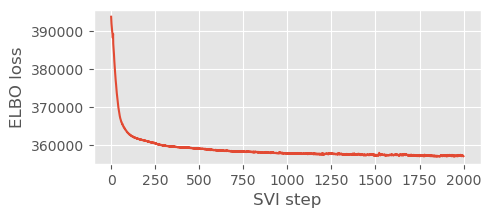

In [24]:
plt.figure(figsize=(5, 2))
plt.plot(loss)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

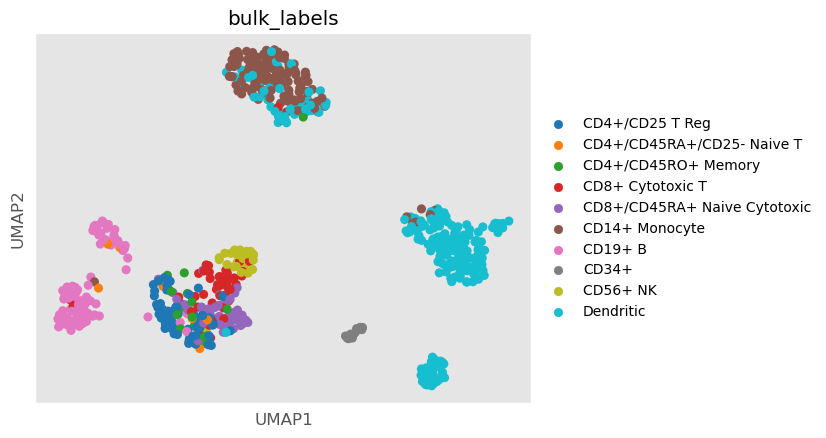

In [25]:
sc.pl.umap(adata, color = "bulk_labels")

In [26]:
sc.pp.neighbors(adata_new, use_rep="X_svgsa_uns")
sc.tl.umap(adata_new, n_components=2)


In [27]:
print( adata_new.obsm["X_svgsa_gs"].shape )
adata_new.obsm["X_svgsa_gs"]

(700, 2)


array([[ 0.11944632, -0.04535114],
       [ 0.11944632, -0.04535114],
       [ 0.11944632, -0.04535114],
       ...,
       [ 0.11944632, -0.04535114],
       [ 0.11944632, -0.04535114],
       [ 0.11944632, -0.04535114]])

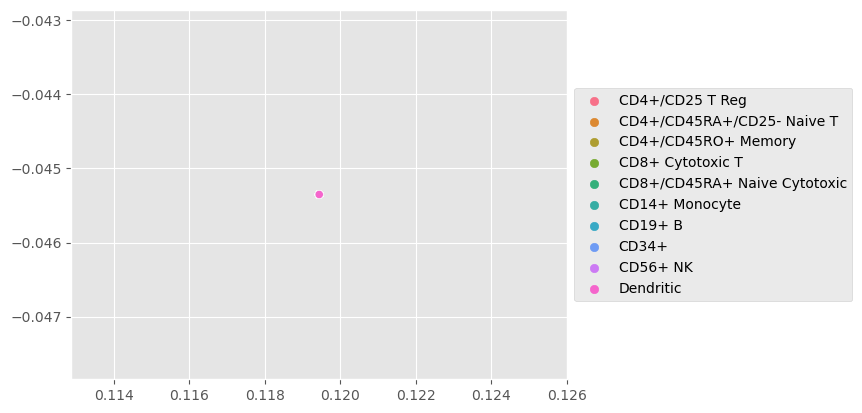

In [28]:
import seaborn as sns

sns.scatterplot(x = adata_new.obsm["X_svgsa_gs"][:,0], y = adata_new.obsm["X_svgsa_gs"][:,1], hue = adata_new.obs.bulk_labels )
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

In [29]:
print( adata_new.obsm["X_svgsa_uns"].shape )
adata_new.obsm["X_svgsa_uns"]

(700, 2)


array([[-0.47634136,  0.3527305 ],
       [-0.45822108,  0.64776912],
       [ 0.67383376, -3.22217573],
       ...,
       [ 0.70546505, -0.16932231],
       [-1.13432632, -2.24031224],
       [-1.52219668, -0.34272367]])

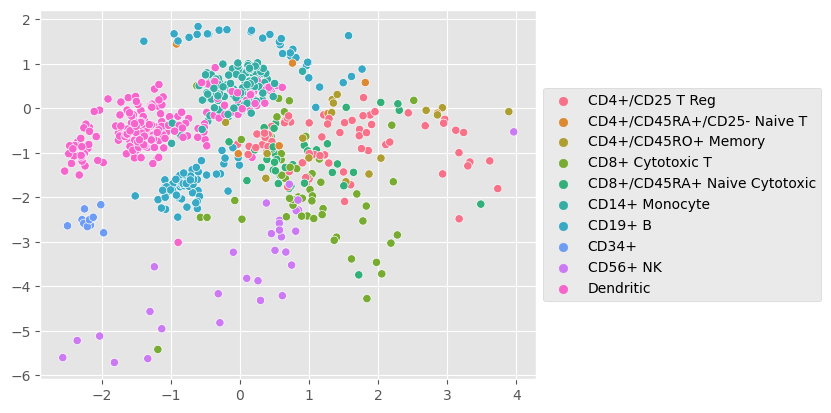

In [30]:
sns.scatterplot(x = adata_new.obsm["X_svgsa_uns"][:,0], y = adata_new.obsm["X_svgsa_uns"][:,1], hue = adata_new.obs.bulk_labels )
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

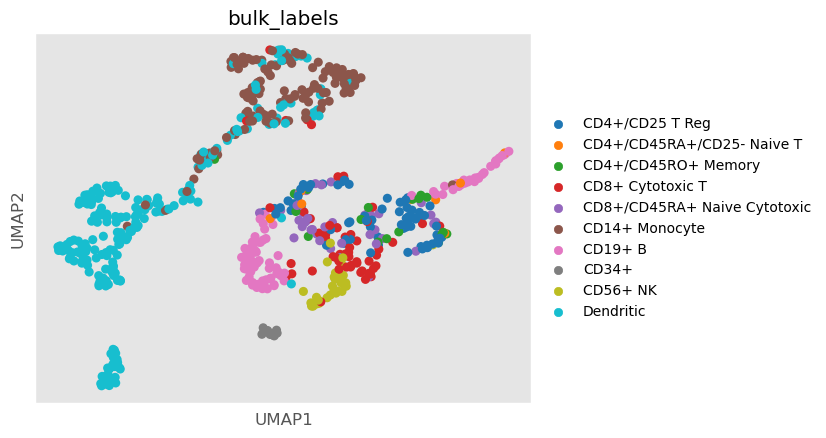

In [31]:
sc.pl.umap(adata_new, color = "bulk_labels")

In [34]:
print(adata_new.obsm["X_reconstructed"])

[[ 0.57716911 -0.12226951 -0.20003694 ...  0.64457734 -0.29877667
   0.48491504]
 [ 1.02835809  0.2120566  -0.1213937  ...  0.8568104  -0.07089984
  -0.05380953]
 [-0.35398005  0.10050707 -0.16523706 ...  1.10274107  0.96759967
  -0.02603184]
 ...
 [-0.10809737  0.20681439 -0.41932093 ... -0.48955705 -0.03420505
   0.21161718]
 [-0.22312663 -0.06572553 -0.16124662 ... -0.61469901 -0.51243578
  -0.00154719]
 [-0.36524    -0.24681496 -0.11334175 ...  0.15117452 -0.04179174
  -0.01227694]]


In [35]:
torch.tensor(adata.X)

tensor([[-0.3260, -0.7280, -0.3010,  ...,  0.5190, -0.6360,  4.0110],
        [ 1.1710,  0.7950, -1.2000,  ...,  1.1720,  2.6300, -0.4900],
        [-0.3260,  0.4830, -1.2000,  ...,  0.7220,  0.6630, -0.4900],
        ...,
        [-0.3260, -0.7280, -1.2000,  ...,  0.1520, -0.6360,  1.2260],
        [-0.3260, -0.7280, -0.3860,  ..., -0.3260, -0.6360, -0.4900],
        [-0.3260,  0.1480,  0.7620,  ...,  0.2390, -0.6360, -0.4900]],
       dtype=torch.float32)

# Standard analysis

In [37]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [38]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [39]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [40]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


c:\Users\Lorzo\miniconda3\envs\thesis_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
c:\Users\Lorzo\miniconda3\envs\thesis_env\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [41]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


In [42]:
sc.pp.scale(adata, max_value=10)


In [43]:
sc.tl.pca(adata, svd_solver='arpack')


In [44]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


In [45]:
sc.tl.umap(adata)


In [46]:
sc.tl.leiden(adata)


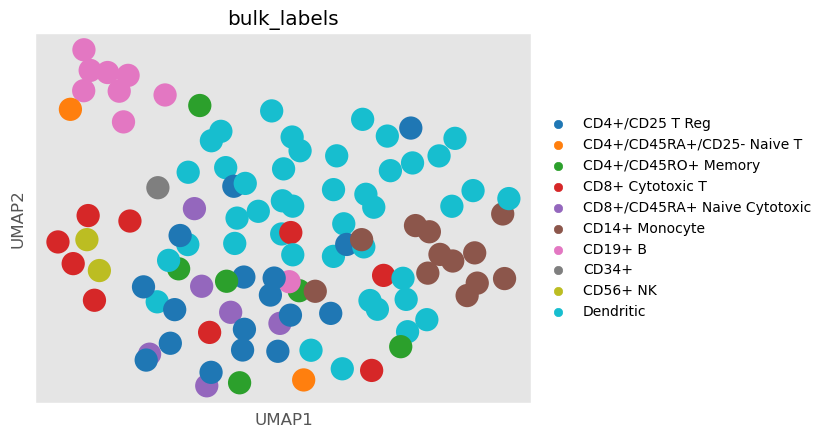

In [47]:
sc.pl.umap(adata,  color = "bulk_labels")